In [13]:
import time 
import matplotlib.pyplot as plt
from tqdm import tqdm 
import seaborn as sns
import pandas as pd

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import random_split

from gpytorch.kernels import  MaternKernel
from linear_operator.utils.cholesky import psd_safe_cholesky
from sklearn.cluster import KMeans
import sys 
sys.path.append('../')
from data.get_uci import  PoleteleDataset 

np.random.seed(42)
torch.manual_seed(42)
global_dtype=torch.float32
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [14]:
pol = PoleteleDataset("../data/uci_datasets/uci_datasets/pol/data.csv")
dataset = pol
train_frac = 4 / 9
val_frac = 2 / 9
train_size = int(len(dataset) * train_frac)
val_size = int(len(dataset) * val_frac)
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Prepare training data
train_data, train_labels = zip(*[(torch.tensor(features, dtype=global_dtype), torch.tensor(labels, dtype=global_dtype)) for features, labels in train_dataset])
train_features = torch.stack(train_data).squeeze(-1).to(device)
train_labels = torch.stack(train_labels).squeeze(-1).to(device)

# Prepare test data
test_data, test_labels = zip(*[(torch.tensor(features, dtype=global_dtype), torch.tensor(labels, dtype=global_dtype)) for features, labels in test_dataset])
test_features = torch.stack(test_data).squeeze(-1).to(device)
test_labels = torch.stack(test_labels).squeeze(-1).to(device)

SIZE (15000, 27)


In [15]:
sigma=.05
_lambda=sigma**2/train_features.shape[0]
lengthscale = 0.1 

num_inducing_points = int(train_features.shape[0] * .1)
print("total inducing points : ",num_inducing_points)

kmeans = KMeans(n_clusters=num_inducing_points, random_state=0).fit(train_features.cpu().numpy())
inducing_points = torch.tensor(kmeans.cluster_centers_, dtype=global_dtype, device=device)

#random landmarks
# inducing_points = train_features[np.random.choice(train_features.shape[0], num_inducing_points, replace=False)]
# inducing_points = torch.tensor(inducing_points, dtype=torch.float32).clone().to(device)

total inducing points :  666


In [16]:
class KernelRidgeRegression:
    def __init__(self, _lambda=1.0, lengthscale=0.1, kernel=None, dtype=torch.float32, device=torch.device('cpu')):
        self.dtype = dtype
        self.device = device
        self.kernel = kernel(nu=1.5, lengthscale=lengthscale).to(self.device)
        self._lambda = torch.tensor(_lambda, dtype=self.dtype, device=self.device, requires_grad=True)

    def fit(self, X, y):
        self.X_train = X.to(self.device)
        self.y_train = y.to(self.device)
        self.K_xx = self.kernel(self.X_train, self.X_train).to(self.dtype).to(self.device)
        n = self.K_xx.shape[0]
        self.alpha_vector = torch.linalg.solve(self.K_xx + self._lambda * n * torch.eye(n, dtype=self.dtype, device=self.device), self.y_train)

    def predict(self, X):
        K = self.kernel(X, self.X_train,).to(self.dtype).to(self.device)
        return torch.matmul(K, self.alpha_vector)

    def objective_function(self,X,y):
        y_pred = self.predict(X)
        n = len(y)
        mse_loss = (1 / n) * torch.sum((y - y_pred) ** 2)
        regularization_term = self._lambda * torch.norm(self.alpha_vector) ** 2
        return mse_loss + regularization_term

krr = KernelRidgeRegression(_lambda=_lambda, lengthscale=lengthscale, kernel=MaternKernel, dtype=global_dtype,device=device)

start_fit = time.time() #<
krr.fit(train_features, train_labels)
end_fit = time.time() #<
Krr_fit_runtime = end_fit-start_fit

start_pred = time.time() #<
Krr_preds = krr.predict(test_features)
end_pred = time.time() #<
Krr_predict_runtime = end_pred-start_pred


Krr_preds = Krr_preds.cpu().detach().numpy()
test_labels_np = test_labels.cpu().detach().numpy()
Krr_rmse = np.sqrt(np.mean((Krr_preds - test_labels_np) ** 2))
print(f"RMSE: {Krr_rmse}")
print("Krr fit runtime:",Krr_fit_runtime)
print("Krr predict runtime:",Krr_predict_runtime)

RMSE: 0.438892662525177
Krr fit runtime: 3.9836480617523193
Krr predict runtime: 0.9897661209106445


In [17]:
class GaussianProcessRegression:
    def __init__(self, lengthscale=1.0, sigma=0.1, dtype=torch.float32, kernel=MaternKernel, device=torch.device('cpu')):
        self.dtype = dtype
        self.device = device
        self.sigma = torch.tensor(sigma, dtype=self.dtype, device=self.device)
        self.kernel = kernel(nu=1.5, lengthscale=lengthscale).to(self.device)

    def fit(self, X, y):
        self.X_train = X.to(dtype=self.dtype, device=self.device)
        y = y.to(dtype=self.dtype, device=self.device)
        K = self.kernel(self.X_train, self.X_train) + self.sigma ** 2 * torch.eye(len(X), dtype=self.dtype, device=self.device)
        self.L = torch.linalg.cholesky(K.to_dense())
        self.alpha = torch.cholesky_solve(y, self.L)

    def predict(self, X):
        X = X.to(dtype=self.dtype, device=self.device)
        K_trans = self.kernel(X, self.X_train).to_dense()
        K = self.kernel(X, X).to_dense()
        mean = K_trans @ self.alpha
        v = torch.cholesky_solve(K_trans.t(), self.L)
        covariance = K - K_trans @ v
        return mean.squeeze(), covariance
    
    def mll(self, X,y):
        K = self.kernel(X, X)
        K += self.sigma * torch.eye(X.shape[0]).to(self.device)

        L = torch.linalg.cholesky(K)
        log_det_K = 2 * torch.sum(torch.log(torch.diagonal(L)))

        alpha = torch.linalg.solve(L.T, torch.linalg.solve(L, y))
        quad_form = torch.dot(y.T, alpha)
        n = len(y)
        mll = -0.5 * log_det_K - 0.5 * quad_form - 0.5 * n * torch.log(torch.tensor(2 * torch.pi,dtype=self.dtype))

        return mll


gpr = GaussianProcessRegression(lengthscale=lengthscale, sigma=sigma,dtype=global_dtype,kernel=MaternKernel,device=device)

start_fit = time.time() #<
gpr.fit(train_features, train_labels.unsqueeze(1))
end_fit = time.time() #<
gpr_fit_runtime = end_fit-start_fit

start_pred = time.time() #<
mean_torch, covariance_torch = gpr.predict(test_features)
end_pred = time.time() #<
gpr_pred_runtime = end_pred- start_pred

GP_mean = mean_torch.cpu().detach().numpy()
GP_covariance = covariance_torch.cpu().detach().numpy()
std = np.sqrt(np.diag(GP_covariance))

test_labels_np = test_labels.cpu().detach().numpy()
gpr_rmse = np.sqrt(np.mean((GP_mean - test_labels_np) ** 2))
print(f"GPR RMSE: {gpr_rmse:.4f}")
print("GPR fit runtime:",gpr_fit_runtime)
print("GPR predict runtime:",gpr_pred_runtime)

GPR RMSE: 0.3537
GPR fit runtime: 5.291959285736084
GPR predict runtime: 8.86344599723816


In [18]:
class NystromKRR(torch.nn.Module):
    def __init__(self, _lambda=1.0, lengthscale=0.1, kernel=RBFKernel, Z=None, dtype=torch.float32, device=torch.device('cpu')):
        super(NystromKRR, self).__init__()
        self.device = device

        self.kernel = kernel(nu=1.5, lengthscale=lengthscale).to(self.device)
        self.Z = Z
        self.dtype = dtype

        self.lengthscale = torch.tensor(lengthscale, dtype=self.dtype, device=self.device)
        self._lambda = nn.Parameter(torch.tensor(_lambda, dtype=self.dtype, device=self.device))


    def fit(self, X, y):
        self.X_train = X.to(dtype=self.dtype, device=self.device)
        self.y_train = y.to(dtype=self.dtype, device=self.device)
        n = X.shape[0]
        
        K_ZZ = self.kernel(self.Z, self.Z).to(dtype=self.dtype, device=self.device).to_dense()
        K_XZ = self.kernel(self.X_train, self.Z).to(dtype=self.dtype, device=self.device).to_dense()
        K_ZX = K_XZ.T
        
        A = K_ZX @ K_XZ + n * self._lambda * K_ZZ
        b = K_ZX @ self.y_train
        self.beta = torch.linalg.solve(A, b)

    def predict(self, test_x):
        K_XZ = self.kernel(test_x, self.Z).to(dtype=self.dtype, device=self.device)
        return K_XZ @ self.beta

    def objective_function(self, X, y):
        y_pred = self.predict(X)
        n = len(y)
        mse_loss = (1 / n) * torch.sum((y - y_pred) ** 2)
        regularization_term = self._lambda * torch.norm(  self.beta) ** 2
        return mse_loss + regularization_term


nystrom_krr = NystromKRR(_lambda=_lambda, lengthscale=lengthscale, Z=inducing_points, kernel=MaternKernel,dtype=global_dtype,device=device)
nystrom_krr.fit(train_features, train_labels)

start_fit = time.time() #<
NKrr_preds = nystrom_krr.predict(test_features)
end_fit = time.time() #<
Nkrr_fit_runtime = end_fit-start_fit 

start_predict = time.time() #<
NKrr_preds = NKrr_preds.cpu().detach().numpy()
end_predict = time.time() #<
Nkrr_predict_runtime = end_predict-start_predict 


test_labels_np = test_labels.cpu().detach().numpy()
NKrr_rmse = np.sqrt(np.mean((NKrr_preds - test_labels_np) ** 2))
print(f"NKrr RMSE: {NKrr_rmse}")
print("NKrr fit runtime:",Nkrr_fit_runtime)
print("NKrr predict runtime:",Nkrr_predict_runtime)

NKrr RMSE: 0.539719820022583
NKrr fit runtime: 0.09938883781433105
NKrr predict runtime: 0.0013341903686523438


In [10]:
class SparseVariationalGaussianProcess:
    def __init__(self, inducing_points, lengthscale=1.0, sigma=0.1, kernel=None, dtype=torch.float64, device=torch.device('cpu')):
        self.dtype = dtype
        self.device = device
        self.inducing_points = inducing_points.clone().detach().to(dtype=dtype, device=device)
        self.sigma = torch.tensor(sigma, dtype=self.dtype, device=self.device)
        self.kernel = kernel(nu=1.5, lengthscale=lengthscale).to(self.device)

        if self.dtype == torch.float32:
            self.jitter = 1e-2
        else: 
            self.jitter = 1e-16

    def fit(self, X, y):
        self.X_train = X.to(dtype=self.dtype, device=self.device)
        self.y_train = y.to(dtype=self.dtype, device=self.device)
        self.K_zz = self.kernel(self.inducing_points, self.inducing_points,).to(dtype=self.dtype, device=self.device) + self.jitter * torch.eye(len(self.inducing_points), dtype=self.dtype, device=self.device)
        self.K_zz=self.K_zz.to_dense()
        self.K_zx = self.kernel(self.inducing_points, self.X_train,).to(dtype=self.dtype, device=self.device).to_dense()
        
        self.L_zz = torch.linalg.cholesky(self.K_zz)
        self.K_zz_inv = torch.cholesky_inverse(self.L_zz)
        

    def predict(self, test_x):
        test_x = test_x.to(dtype=self.dtype, device=self.device)
        K_Z = self.kernel(self.inducing_points, test_x).to(dtype=self.dtype, device=self.device).to_dense()
        
        L = torch.linalg.cholesky(self.sigma**2 * self.K_zz + self.K_zx @ self.K_zx.T)
        L_inv = torch.cholesky_inverse(L)
        
        mean_star = K_Z.T @ L_inv @ self.K_zx @ self.y_train
        
        term1 = self.kernel(test_x, test_x).to(dtype=self.dtype, device=self.device)
        term2 = -K_Z.T @ self.K_zz_inv @ K_Z
        
        L_full = torch.linalg.cholesky(self.K_zz + (1 / self.sigma**2) * self.K_zx @ self.K_zx.T)
        L_full_inv = torch.cholesky_inverse(L_full)
        
        term3 = K_Z.T @ L_full_inv @ K_Z
        
        cov_star = term1 + term2 + term3
        
        return mean_star.squeeze(), cov_star

    #TODO: possibly unstable for back prop
    def calculate_elbo(self,X, y):
        sigma_sq = self.sigma**2
        K_xx = self.kernel(X, X,).to(device=self.device).to_dense()
        q_xx = self.K_zx.T @ self.K_zz_inv @ self.K_zx
        term1 = torch.logdet(q_xx)
        term2 = y.T @ (q_xx + sigma_sq * torch.eye(q_xx.shape[0], device=self.device)) @ y
        term3 = self.X_train.shape[0] * torch.log(torch.tensor(2 * torch.pi,dtype=self.dtype))
        term4 = torch.trace(K_xx - q_xx) / sigma_sq
        return -0.5 * term1 + term2 + term3 + term4
    
svgp = SparseVariationalGaussianProcess(inducing_points, lengthscale=lengthscale, sigma=sigma, kernel=MaternKernel,device=device)

start_fit = time.time() #<
svgp.fit(train_features, train_labels)  
end_fit = time.time() #<
svgp_fit_runtime = end_fit - start_fit

start_predict = time.time() #<
mean_torch, covariance_torch = svgp.predict(test_features)
end_predict = time.time() #<
svgp_predict_runtime = end_predict - start_predict

SVGP_mean = mean_torch.cpu().detach().numpy()
SVG_covariance = covariance_torch.cpu().detach().numpy()
std = np.sqrt(np.diag(SVG_covariance))

test_labels_np = test_labels.cpu().detach().numpy()
svgp_rmse = np.sqrt(np.mean((SVGP_mean - test_labels_np) ** 2))
print(f"SVGP RMSE: {svgp_rmse:.4f}")
print("SVGP fit runtime:",svgp_fit_runtime)
print("SVGP predict runtime:",svgp_predict_runtime)

SVGP RMSE: 0.4715
SVGP fit runtime: 0.09023499488830566
SVGP predict runtime: 1.8849847316741943


4it [00:17,  4.45s/it]


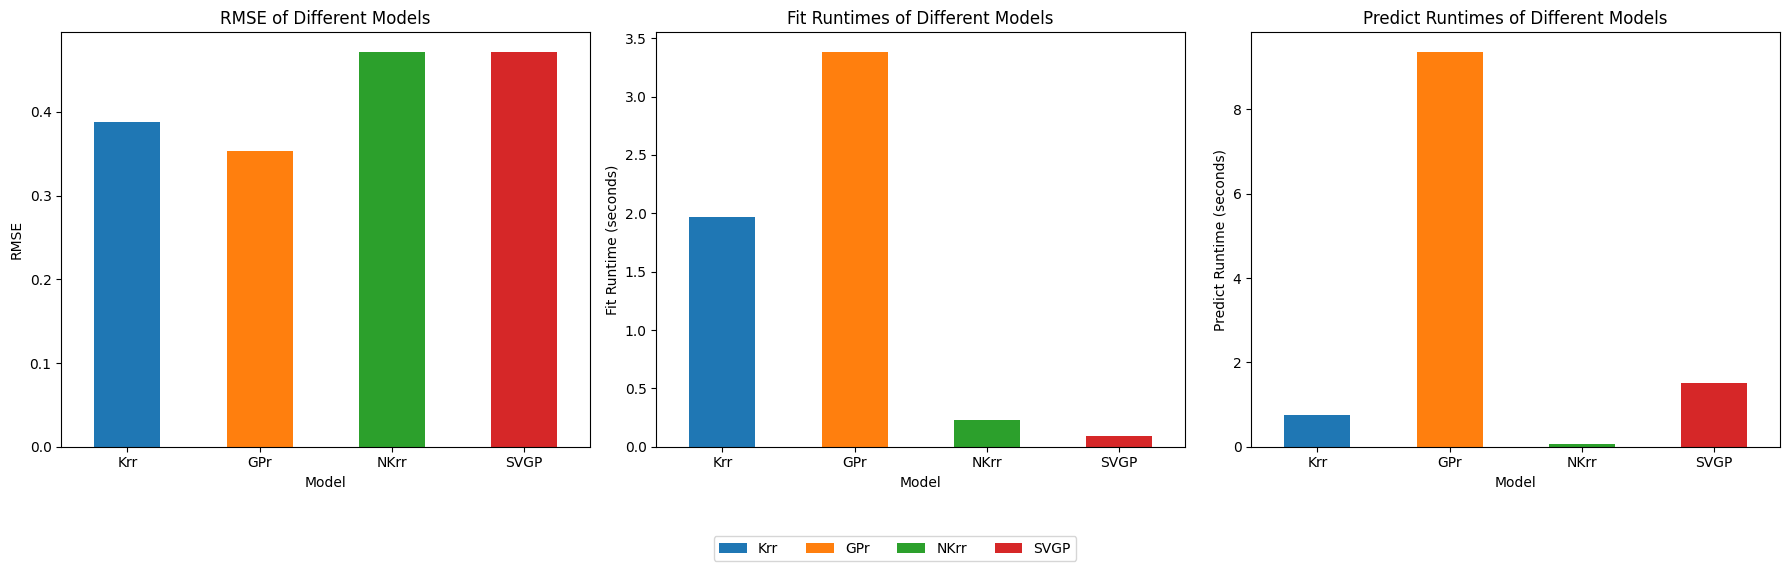

In [11]:
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd

models = [
    KernelRidgeRegression(_lambda=_lambda, lengthscale=lengthscale, kernel=MaternKernel, dtype=global_dtype,device=device),
    GaussianProcessRegression(lengthscale=lengthscale, sigma=sigma, dtype=global_dtype, kernel=MaternKernel,device=device),
    NystromKRR(_lambda=_lambda, lengthscale=lengthscale, Z=inducing_points, kernel=MaternKernel, dtype=global_dtype,device=device),
    SparseVariationalGaussianProcess(inducing_points, lengthscale=lengthscale, sigma=sigma, kernel=MaternKernel,device=device)
]
model_names = ['Krr','GPr','NKrr','SVGP']
results = []
for i, model in tqdm(enumerate(models)):
    model_name = model_names[i]
    
    if model_name == 'GPr':
        fit_args = (train_features, train_labels.unsqueeze(1))
    else:
        fit_args = (train_features, train_labels)
    
    start_fit = time.time()
    model.fit(*fit_args)
    end_fit = time.time()
    fit_runtime = end_fit - start_fit
    
    start_predict = time.time()
    predictions = model.predict(test_features)
    end_predict = time.time()
    predict_runtime = end_predict - start_predict
    
    if isinstance(predictions, tuple):
        mean_torch, covariance_torch = predictions
        preds = mean_torch.cpu().detach().numpy()
        covariance = covariance_torch.cpu().detach().numpy()
        std = np.sqrt(np.diag(covariance))
    else:
        preds = predictions.cpu().detach().numpy()
    
    test_labels_np = test_labels.cpu().detach().numpy()
    rmse = np.sqrt(np.mean((preds - test_labels_np) ** 2))
    
    results.append({
        'Model': model_name,
        'RMSE': rmse,
        'Fit Runtime': fit_runtime,
        'Predict Runtime': predict_runtime
    })

results_df = pd.DataFrame(results)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

results_df.plot(x='Model', y='RMSE', kind='bar', ax=axes[0], color=colors, legend=False)
axes[0].set_ylabel('RMSE')
axes[0].set_title('RMSE of Different Models')

results_df.plot(x='Model', y='Fit Runtime', kind='bar', ax=axes[1], color=colors, legend=False)
axes[1].set_ylabel('Fit Runtime (seconds)')
axes[1].set_title('Fit Runtimes of Different Models')

results_df.plot(x='Model', y='Predict Runtime', kind='bar', ax=axes[2], color=colors, legend=False)
axes[2].set_ylabel('Predict Runtime (seconds)')
axes[2].set_title('Predict Runtimes of Different Models')

for ax in axes:
    ax.set_xticklabels(results_df['Model'], rotation=0)

fig.legend(handles=axes[0].patches, labels=model_names, loc='lower center', ncol=4)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()


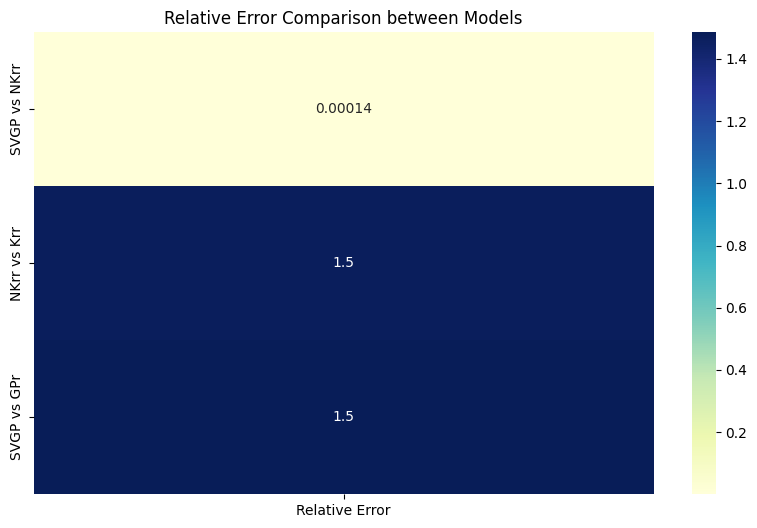

In [12]:
predictions_dict = {}
for i, model in enumerate(models):
    model_name = model_names[i]
    if model_name == 'GPr':
        fit_args = (train_features, train_labels.unsqueeze(1))
    else:
        fit_args = (train_features, train_labels)
    model.fit(*fit_args)
    predictions = model.predict(test_features)
    if isinstance(predictions, tuple):
        mean_torch, covariance_torch = predictions
        preds = mean_torch.cpu().detach().numpy()
    else:
        preds = predictions.cpu().detach().numpy()
    predictions_dict[model_name] = preds

def relative_error(pred1, pred2):
    return np.mean(np.abs(pred1 - pred2) / np.abs(pred1))

comparisons = [
    ('SVGP', 'NKrr'),
    ('NKrr', 'Krr'),
    ('SVGP', 'GPr')
]
relative_errors = {comp: relative_error(predictions_dict[comp[0]], predictions_dict[comp[1]]) for comp in comparisons}

heatmap_data = pd.DataFrame(
    relative_errors.values(),
    index=[f"{comp[0]} vs {comp[1]}" for comp in comparisons],
    columns=["Relative Error"]
)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", cbar=True)
plt.title('Relative Error Comparison between Models')
plt.show()
